In [57]:
from Unet import UNet

In [ ]:
import rasterio
from rasterio.windows import Window
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt

# Assuming UNet is defined elsewhere
# from your_module import UNet

def predict_large_tiff(model_path, input_tiff_path, output_tiff_path, device=None, threshold=None, tile_size=512, visualize_first_n=0):
    """
    Simple prediction for S2 TIFF using /3000 normalization.
    If threshold is None, auto-adjusts to get both 0 and 255 values.
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load model
    model = UNet(in_channels=3, out_channels=1)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # Open input
    with rasterio.open(input_tiff_path) as src:
        profile = src.profile.copy()
        height, width = src.height, src.width
        
        # Initialize mask
        mask = np.zeros((height, width), dtype=np.uint8)
        
        # Transforms
        resize_transform = transforms.Compose([
            transforms.Resize((tile_size, tile_size)),
            transforms.ToTensor()
        ])
        
        vis_count = 0
        all_pred_probs = []  # Collect all probabilities for auto-threshold
        
        # First pass: collect probabilities if auto-threshold needed
        if threshold is None:
            print("🔧 Collecting probabilities for auto-threshold...")
            for i in range(0, height, tile_size):
                for j in range(0, width, tile_size):
                    tile_height = min(tile_size, height - i)
                    tile_width = min(tile_size, width - j)
                    window = Window(col_off=j, row_off=i, width=tile_width, height=tile_height)
                    
                    tile = src.read(window=window, indexes=[1, 2, 3], masked=True)
                    if tile.size == 0 or np.all(tile.mask):
                        continue
                    
                    tile = tile.filled(fill_value=0).astype(np.float32)
                    tile = np.clip(tile / 3000.0, 0, 1)
                    
                    tile_rgb = np.transpose(tile, (1, 2, 0)) * 255
                    tile_rgb = tile_rgb.astype(np.uint8)
                    img_pil = Image.fromarray(tile_rgb, mode='RGB')
                    
                    input_tensor = resize_transform(img_pil).unsqueeze(0).to(device)
                    
                    with torch.no_grad():
                        pred = model(input_tensor)
                        pred_prob = torch.sigmoid(pred)
                        all_pred_probs.append(pred_prob.cpu().numpy())
            
            if all_pred_probs:
                all_probs = np.concatenate([p.flatten() for p in all_pred_probs])
                # Use median as threshold to ensure we get both classes
                threshold = np.median(all_probs)
                print(f"🔧 Auto-selected threshold: {threshold:.3f}")
            else:
                threshold = 0.5
                print("⚠️ Using default threshold: 0.5")
        
        print(f"🎯 Using threshold: {threshold}")
        
        # Second pass: actual prediction
        for i in range(0, height, tile_size):
            for j in range(0, width, tile_size):
                if vis_count >= visualize_first_n:
                    visualize = False
                else:
                    visualize = True
                
                tile_height = min(tile_size, height - i)
                tile_width = min(tile_size, width - j)
                window = Window(col_off=j, row_off=i, width=tile_width, height=tile_height)
                
                # Read RGB (bands 1=Blue, 2=Green, 3=Red)
                tile = src.read(window=window, indexes=[1, 2, 3], masked=True)
                if tile.size == 0 or np.all(tile.mask):
                    # Fill with zeros (non-buildings) for empty areas
                    mask[i:i + tile_height, j:j + tile_width] = 0
                    continue
                
                # Handle nodata → 0
                tile = tile.filled(fill_value=0).astype(np.float32)
                
                # Normalize /3000
                tile = np.clip(tile / 3000.0, 0, 1)
                
                # To HWC uint8
                tile_rgb = np.transpose(tile, (1, 2, 0)) * 255
                tile_rgb = tile_rgb.astype(np.uint8)
                img_pil = Image.fromarray(tile_rgb, mode='RGB')
                
                # Tensor
                input_tensor = resize_transform(img_pil).unsqueeze(0).to(device)
                
                # Predict
                with torch.no_grad():
                    pred = model(input_tensor)
                    pred_prob = torch.sigmoid(pred)
                    pred_binary = (pred_prob > threshold).float()
                
                # Back to numpy & resize (NEAREST)
                pred_np = pred_binary.squeeze().cpu().numpy()
                pred_pil = transforms.ToPILImage()(pred_np.astype(np.float32))
                resize_back = transforms.Resize((tile_height, tile_width), interpolation=Image.NEAREST)
                pred_resized_pil = resize_back(pred_pil)
                
                # Convert to final mask: buildings=255 (white), non-buildings=0 (black)
                pred_resized = (np.array(pred_resized_pil) * 255).astype(np.uint8)
                
                # Assign
                mask[i:i + tile_height, j:j + tile_width] = pred_resized
                
                # Visualize if requested
                if visualize:
                    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
                    # Input RGB
                    axs[0].imshow(tile_rgb)
                    axs[0].set_title(f'Input Tile ({i}, {j})')
                    axs[0].axis('off')
                    
                    # Binary mask
                    axs[1].imshow(pred_resized, cmap='gray')
                    axs[1].set_title(f'Binary Mask (thresh={threshold:.3f})')
                    axs[1].axis('off')
                    
                    plt.tight_layout()
                    plt.show()
                    vis_count += 1
        
        # Print quick summary
        unique_vals, counts = np.unique(mask, return_counts=True)
        print(f"📊 Final mask values: {dict(zip(unique_vals, counts))}")
        
        building_pct = np.sum(mask == 255) / (height * width) * 100
        print(f"✅ Processed. Building pixels: {building_pct:.1f}%")
        
        if building_pct > 90:
            print("⚠️ High detection rate")
        elif building_pct < 5:
            print("⚠️ Low detection rate")
    
    # Save
    profile.update(count=1, dtype=rasterio.uint8, nodata=0)
    with rasterio.open(output_tiff_path, 'w', **profile) as dst:
        dst.write(mask, 1)
    
    print(f"✅ Mask saved: {output_tiff_path}")
    print("🗺️ ArcGIS: Use 'Unique Values' symbology with 0=Black, 255=White")



C:\Users\vedan\AppData\Local\Temp\ipykernel_5580\2400541328.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

🎯 Using threshold: 0.9999


C:\Users\vedan\AppData\Local\Temp\ipykernel_5580\2400541328.py:109: RuntimeWarning: invalid value encountered in cast
  tile_rgb = tile_rgb.astype(np.uint8)


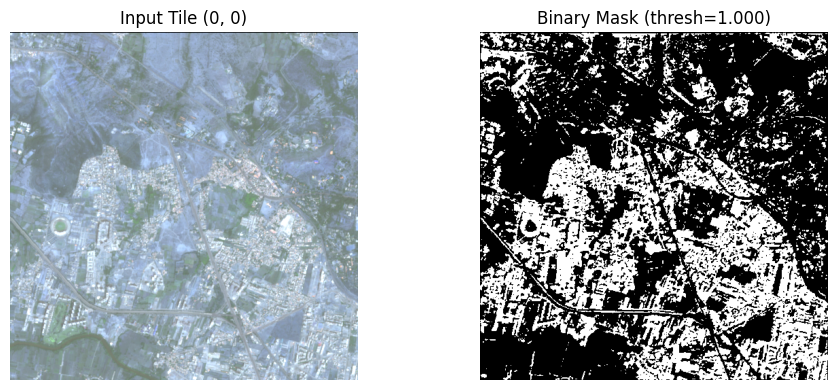

📊 Final mask values: {np.uint8(0): np.int64(7539936), np.uint8(1): np.int64(3625686)}
✅ Processed. Building pixels: 0.0%
⚠️ Low detection rate
✅ Mask saved: ./Tiff/Pune_pos/Post_UrbanMasked.tif
🗺️ ArcGIS: Use 'Unique Values' symbology with 0=Black, 255=White


In [82]:
predict_large_tiff(
    model_path="./unet_best.pth",
    input_tiff_path="./Tiff/Pune_pos/Pune_StudyArea_2023.tif",
    output_tiff_path="./Tiff/Pune_pos/Post_UrbanMasked.tif",
    tile_size=512,
    threshold=0.9999,
    visualize_first_n=1
)


C:\Users\vedan\AppData\Local\Temp\ipykernel_5580\2400541328.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

🎯 Using threshold: 0.9999


C:\Users\vedan\AppData\Local\Temp\ipykernel_5580\2400541328.py:109: RuntimeWarning: invalid value encountered in cast
  tile_rgb = tile_rgb.astype(np.uint8)


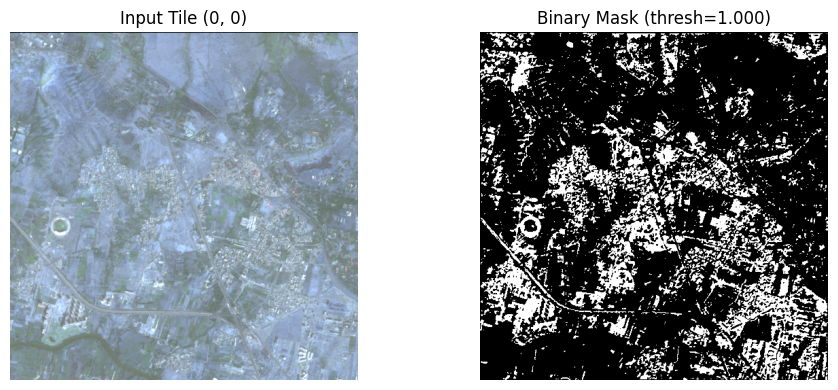

📊 Final mask values: {np.uint8(0): np.int64(9021500), np.uint8(1): np.int64(2144122)}
✅ Processed. Building pixels: 0.0%
⚠️ Low detection rate
✅ Mask saved: ./Tiff/Pune_Pre/Pre_UrbanMasked.tif
🗺️ ArcGIS: Use 'Unique Values' symbology with 0=Black, 255=White


In [83]:
predict_large_tiff(
    model_path="./unet_best.pth",
    input_tiff_path="./Tiff/Pune_Pre/Pune_StudyArea_2016.tif",
    output_tiff_path="./Tiff/Pune_Pre/Pre_UrbanMasked.tif",
    tile_size=512,
    threshold=0.9999,
    visualize_first_n=1
)

In [88]:
import os

name="Pune_pos"
# name="Pune_Pre"
# file_name="Pune_Post"
# file_name="Pune_StudyArea_2016.tif"
file_name="Pune_StudyArea_2023"

directory = f"./Tiff/{name}"

if not os.path.exists(directory):
    os.makedirs(directory)

In [90]:
import numpy as np
import rasterio
import os

# Input TIFF exported from Earth Engine
input_tiff = f"./Tiff/{name}/{file_name}.tif"

name="Pune_Tiffs"
# Output file paths
output_ndvi     = f"./Tiff/{name}/NDVI_post.tif"
output_ndbi     = f"./Tiff/{name}/NDBI_post.tif"
output_ndwi     = f"./Tiff/{name}/NDWI_post.tif"
output_ndmi     = f"./Tiff/{name}/NDMI_post.tif"
output_lst      = f"./Tiff/{name}/LST_post.tif"
output_slope    = f"./Tiff/{name}/Slope_post.tif"
# output_ndbi_mask= f"./Tiff/{name}/NDBI_Mask_post.tif"

with rasterio.open(input_tiff) as src:
    
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)

    # Read bands from EE export
    blue    = src.read(1).astype('float32')  # Blue
    green   = src.read(2).astype('float32')  # Green
    red     = src.read(3).astype('float32')  # Red
    nir     = src.read(4).astype('float32')  # NIR
    swir1   = src.read(5).astype('float32')  # SWIR1
    swir2   = src.read(6).astype('float32')  # SWIR2
    thermal = src.read(7).astype('float32')  # Thermal
    dem     = src.read(8).astype('float32')  # DEM

    # 1) NDVI
    ndvi = (nir - red) / (nir + red + 1e-6)
    with rasterio.open(output_ndvi, "w", **profile) as dst:
        dst.write(ndvi, 1)

    # 2) NDBI (Urban Built-up)
    ndbi = (swir1 - nir) / (swir1 + nir + 1e-6)
    with rasterio.open(output_ndbi, "w", **profile) as dst:
        dst.write(ndbi, 1)

    # 3) NDWI (Water Index)
    ndwi = (green - nir) / (green + nir + 1e-6)
    with rasterio.open(output_ndwi, "w", **profile) as dst:
        dst.write(ndwi, 1)

    # 4) NDMI (Moisture Index)
    ndmi = (nir - swir1) / (nir + swir1 + 1e-6)
    with rasterio.open(output_ndmi, "w", **profile) as dst:
        dst.write(ndmi, 1)

    # 5) Land Surface Temperature Approximation
    lst = thermal * 0.00341802 + 149.0

    # Normalize LST
    lst_min = np.min(lst)
    lst_max = np.max(lst)
    lst_normalized = (lst - lst_min) / (lst_max - lst_min)
    lst_normalized = np.nan_to_num(lst_normalized, nan=0.0, posinf=1.0, neginf=0.0)
    lst_normalized = np.clip(lst_normalized, 0.0, 1.0)

    with rasterio.open(output_lst, "w", **profile) as dst:
        dst.write(lst_normalized, 1)

    # 6) Slope from DEM
    gy, gx = np.gradient(dem, 30)  # assuming 30m spatial resolution
    slope = np.degrees(np.arctan(np.sqrt(gx**2 + gy**2)))
    with rasterio.open(output_slope, "w", **profile) as dst:
        dst.write(slope, 1)




print("\nAll layers generated successfully:")
print(output_ndvi)
print(output_ndbi)
print(output_ndwi)
print(output_ndmi)
print(output_lst)
print(output_slope)
# print(output_ndbi_mask)



All layers generated successfully:
./Tiff/Pune_Tiffs/NDVI_post.tif
./Tiff/Pune_Tiffs/NDBI_post.tif
./Tiff/Pune_Tiffs/NDWI_post.tif
./Tiff/Pune_Tiffs/NDMI_post.tif
./Tiff/Pune_Tiffs/LST_post.tif
./Tiff/Pune_Tiffs/Slope_post.tif
